In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord
import pdb
import matplotlib.pyplot as plt
import h5py    
import pandas as pd

import sklearn
print(sklearn.__version__)

import seaborn as sns

1.1.2


In [2]:
data_path = "/Users/marchuertascompany/Documents/data/CEERS/adversarial/"
ceers_cat = pd.read_csv(data_path+"Jeyhan_DL_match_1122_ensemble_bug.csv")
ceers_cat = ceers_cat.fillna(0)


In [3]:
filters = ['f200w','f356w','f444w']
morph=['sph','disk','irr','bd']

for f in filters:
    for m in morph:
        c = ceers_cat.filter(regex='^'+m+'_')
        c = c.filter(regex=f+'$')
        ceers_cat[m+'_'+f+'_mean']=c.mean(axis=1).values
        ceers_cat[m+'_'+f+'_std']=c.std(axis=1).values
#print(c.mean(axis=1))
#print(c.std(axis=1))
#c=ceers_cat[ceers_cat.name.str.match('sph*f200w')]
#print(c.columns)

In [4]:

morph_flag=[]
delta_value = []

for sph,dk,irr,bd in zip(ceers_cat.sph_f200w_mean,ceers_cat.disk_f200w_mean,ceers_cat.irr_f200w_mean,ceers_cat.bd_f200w_mean):
    maxpos = np.argmax([sph,dk,irr,bd])
    delta = np.sort([sph,dk,irr,bd])[3]-np.sort([sph,dk,irr,bd])[2]
    morph_flag.append(maxpos)
    delta_value.append(delta)
#morph_flag=np.array(morph_flag)
#morph_flag[(ceers_cat.disk_f200>0.3)]=1    
ceers_cat['morph_flag_f200w']=np.array(morph_flag)
ceers_cat['delta_f200']=np.array(delta_value)


In [5]:
morph_flag=[]
k=0
for spheroid,disk,irregular,ps,uncl in zip(ceers_cat.spheroid,ceers_cat.disk, ceers_cat.irregular, ceers_cat.ps, ceers_cat.unclassifiable):
    k+=1
    #print(spheroid,disk, irregular, ps, uncl)
    if (spheroid>=2 and disk<2 and irregular<2 and ps<2 and uncl<2):
        morph_flag.append(0)
        #print(k,0)
    elif (spheroid>=2 and disk>=2 and irregular<2 and ps<2 and uncl<2):
        morph_flag.append(1)
    elif (spheroid>=2 and disk>=2 and irregular>=2 and ps<2 and uncl<2):
        morph_flag.append(3)  
    elif (spheroid>=2 and disk<2 and irregular>=2 and ps<2 and uncl<2):
        morph_flag.append(2)        

    elif (spheroid<2 and disk>=2 and irregular<2 and ps<2 and uncl<2):
        morph_flag.append(4)
        #print(k,1)
    elif (spheroid<2 and disk>=2 and irregular>=2 and ps<2 and uncl<2):
        morph_flag.append(5)
        #print(k,2)
    
        #print(k,3)
    
        #print(k,5)   
    
        #print(k,6)  
    elif (spheroid<2 and disk<2 and irregular>=2 and ps<2 and uncl<2):
        morph_flag.append(6) 
        #print(k,7)    
    elif ( (ps>=2 or uncl>=2) and (spheroid<2 and disk<2 and irregular<2)):
        morph_flag.append(7) 
        #print(k,8)
    else:
        morph_flag.append(-1)    
ceers_cat['morph_flag_visual']=np.array(morph_flag)                              

[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[0.63157895 0.21052632 0.0877193  0.         0.05263158 0.01754386
 0.         0.        ]
0.9298245614035088


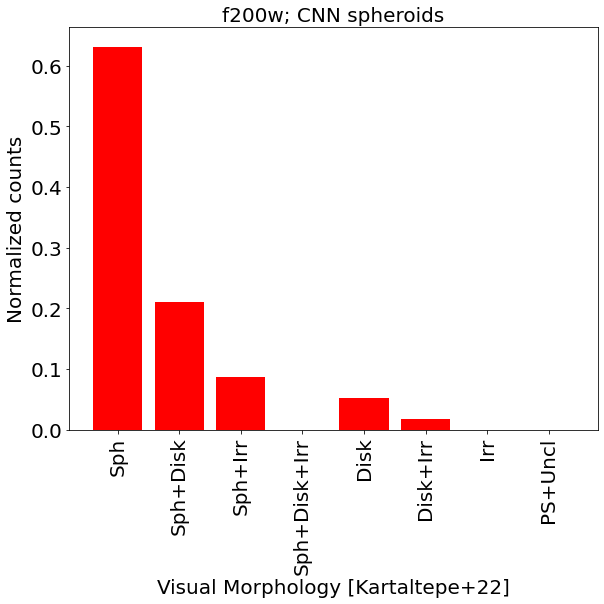

In [6]:
sel = ceers_cat.query("morph_flag_f200w==0 and morph_flag_visual>-1 and delta_f200>0.5")
all,bins = np.histogram(sel.morph_flag_visual,range=(0,8),density=True,bins=8)
bcenters = (bins[1:] + bins[:-1])/2
print(bins)
print(all)
print(np.sum(all[0:3]))
fig = plt.figure()
fig.set_size_inches(8.5, 8.5)
plt.bar(bcenters,all,tick_label=["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"],color='red')
plt.xticks(bcenters, ["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"], rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Visual Morphology [Kartaltepe+22]",fontsize=20)
plt.ylabel("Normalized counts",fontsize=20)
plt.title("f200w; CNN spheroids",fontsize=20)
plt.tight_layout()

plt.savefig(data_path+"morph_jeyhan_0.png")

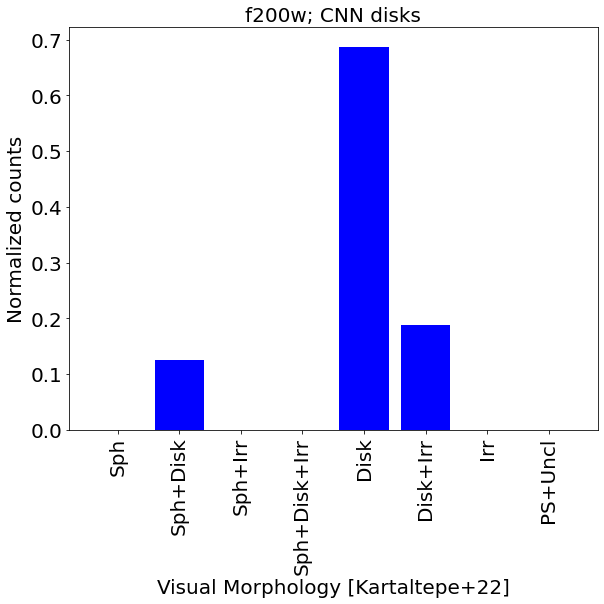

In [12]:
sel = ceers_cat.query("morph_flag_f200w==1 and morph_flag_visual>-1 and delta_f200>0.3")
all,bins = np.histogram(sel.morph_flag_visual,range=(0,8),density=True,bins=8)
bcenters = (bins[1:] + bins[:-1])/2

fig = plt.figure()
fig.set_size_inches(8.5, 8.5)
plt.bar(bcenters,all,tick_label=["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"],color='blue')
plt.xticks(bcenters, ["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"], rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Visual Morphology [Kartaltepe+22]",fontsize=20)
plt.ylabel("Normalized counts",fontsize=20)
plt.title("f200w; CNN disks",fontsize=20)
plt.tight_layout()
plt.savefig(data_path+"morph_jeyhan_1.png")

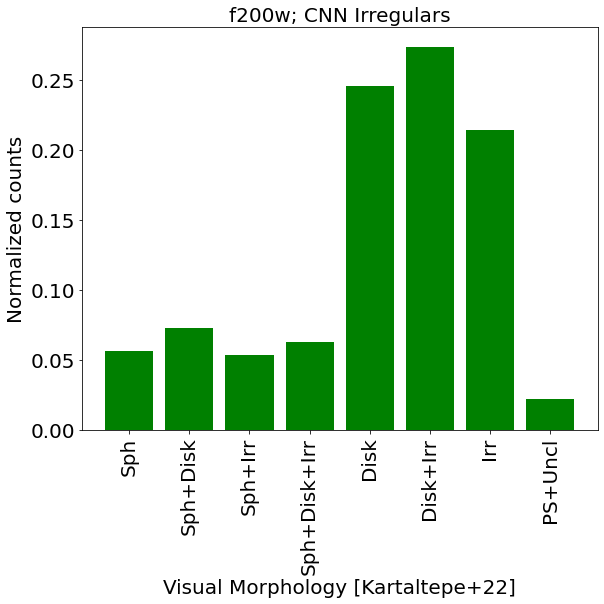

In [11]:
sel = ceers_cat.query("morph_flag_f200w==2 and morph_flag_visual>-1 and delta_f200>0.3")
all,bins = np.histogram(sel.morph_flag_visual,range=(0,8),density=True,bins=8)
bcenters = (bins[1:] + bins[:-1])/2

fig = plt.figure()
fig.set_size_inches(8.5, 8.5)
plt.bar(bcenters,all,tick_label=["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"],color='green')
plt.xticks(bcenters, ["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"], rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Visual Morphology [Kartaltepe+22]",fontsize=20)
plt.ylabel("Normalized counts",fontsize=20)
plt.title("f200w; CNN Irregulars",fontsize=20)
plt.tight_layout()
plt.savefig(data_path+"morph_jeyhan_2.png")

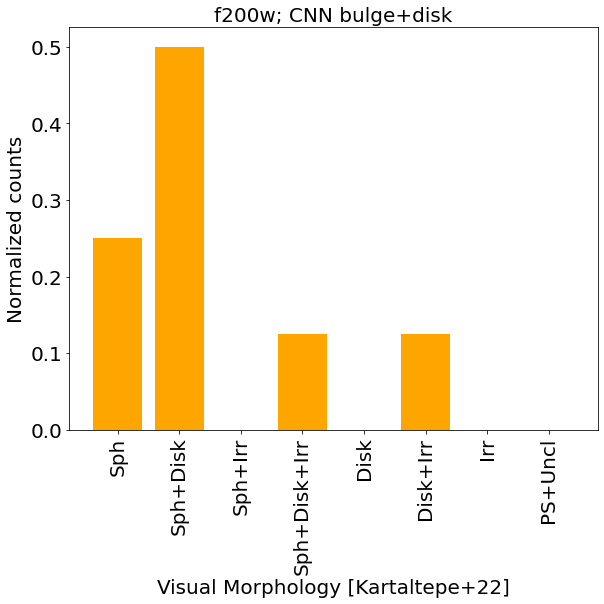

In [10]:
sel = ceers_cat.query("morph_flag_f200w==3 and morph_flag_visual>-1")
all,bins = np.histogram(sel.morph_flag_visual,range=(0,8),density=True,bins=8)
bcenters = (bins[1:] + bins[:-1])/2

fig = plt.figure()
fig.set_size_inches(8.5, 8.5)
plt.bar(bcenters,all,tick_label=["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"],color='orange')
plt.xticks(bcenters, ["Sph","Sph+Disk","Sph+Irr","Sph+Disk+Irr","Disk","Disk+Irr","Irr","PS+Uncl"], rotation=90,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Visual Morphology [Kartaltepe+22]",fontsize=20)
plt.ylabel("Normalized counts",fontsize=20)
plt.title("f200w; CNN bulge+disk",fontsize=20)
plt.tight_layout()
plt.savefig(data_path+"morph_jeyhan_3.png")

2.9374101449275356
0.19137723320425534
1.599521052631579
0.09265263426940495
1.584758130081301
0.1166513449778169
2.4785
0.11746867925808067


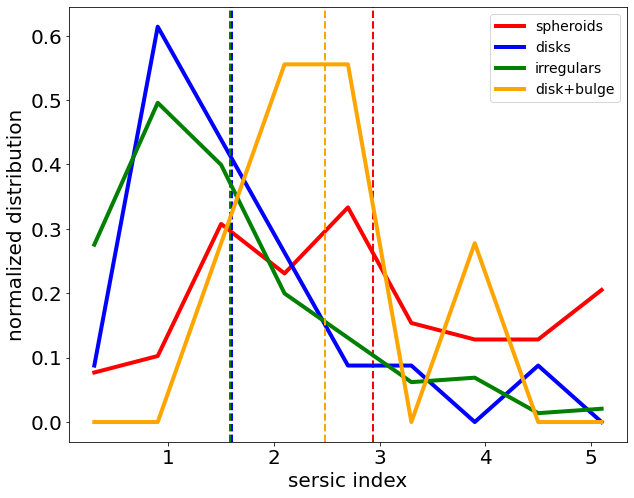

In [8]:
def nmad(data):
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    scale_factor = np.percentile(data, 98)
    nmad_value = mad / scale_factor
    return nmad_value

# Assuming you have imported 'sel' and 'n_f200' from the previous lines

sel = ceers_cat.query("morph_flag_f200w==0 and morph_flag_visual>-1 and delta_f200>0.5")
n_f200 = sel['F200W_N']

# Define the bin edges
bin_edges = list(np.arange(0, 6, .6))
#print(bin_edges)

# Create a list of morph_flag_f200w values to loop through
morph_flag_f200w_values = [0, 1, 2, 3]

# Set up colors for each morph_flag_f200w value
colors = ['red', 'blue', 'green', 'orange']

# Labels for the legend
legend_labels = ["spheroids", "disks", "irregulars", "disk+bulge"]

# Create subplots to hold the histograms
fig, ax = plt.subplots(figsize=(10, 8))

# Iterate over the morph_flag_f200w values and plot the histograms
for i, morph_flag_f200w_value in enumerate(morph_flag_f200w_values):
    sel = ceers_cat.query(f"F200W_FLAG==0 and F200W_N > 0 and F200W_N<7 and morph_flag_f200w=={morph_flag_f200w_value} and morph_flag_visual>-1")
    n_f200 = sel['F200W_N']
    
    # Compute the normalized histogram using numpy
    hist, bin_edges = np.histogram(n_f200, bins=bin_edges, density=True)
    
    # Calculate the bin centers for the line plot
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    mean_n_f200 = n_f200.mean()
    print(mean_n_f200)
    print(nmad(n_f200))
    
    # Plot the normalized distribution as a line plot with the corresponding color
    ax.plot(bin_centers, hist, color=colors[i], linewidth=4, label=legend_labels[i])
    ax.axvline(x=mean_n_f200, color=colors[i], linestyle='--', linewidth=2)

# Set axis labels and fontsize
ax.set_xlabel("sersic index", fontsize=20)
ax.set_ylabel("normalized distribution", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

# Add a legend to differentiate the morph_flag_f200w values
ax.legend(fontsize=14)

# Show the plot
plt.savefig(data_path+"sersic_distribution_kartaltepe.png")
plt.show()

In [10]:
from tabulate import tabulate
def nmad(data):
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    scale_factor = np.percentile(data, 98)
    nmad_value = mad / scale_factor
    return nmad_value

# Your existing code ...

# Collect the mean and NMAD values for each morph_flag_f200w category
mean_values = []
nmad_values = []

for i, morph_flag_f200w_value in enumerate(morph_flag_f200w_values):
    sel = ceers_cat.query(f"F200W_FLAG==0 and F200W_N > 0 and F200W_N<7 and morph_flag_f200w=={morph_flag_f200w_value} and morph_flag_visual>-1")
    n_f200 = sel['F200W_N']
    mean_value = n_f200.mean()
    nmad_value = nmad(n_f200)
    mean_values.append(mean_value)
    nmad_values.append(nmad_value)

# Create a list of lists to represent the table data
table_data = [
    [legend_labels[i], mean_values[i], nmad_values[i]] for i in range(len(morph_flag_f200w_values))
]

# Define the table headers
table_headers = ["Morph Flag", "Mean", "NMAD"]

# Generate the LaTeX table
latex_table = tabulate(table_data, headers=table_headers, tablefmt="latex")

# Print the LaTeX table
print(latex_table)

\begin{tabular}{lrr}
\hline
 Morph Flag   &    Mean &      NMAD \\
\hline
 spheroids    & 2.93741 & 0.191377  \\
 disks        & 1.59952 & 0.0926526 \\
 irregulars   & 1.58476 & 0.116651  \\
 disk+bulge   & 2.4785  & 0.117469  \\
\hline
\end{tabular}


In [48]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tabulate import tabulate

# Assuming you have imported 'sel' and 'n_f200' from the previous lines

# Define the bin edges for "sersic index"
bin_edges_sersic = np.linspace(0, 7, num=9, endpoint=True)

# Create a list of morph_flag_f200w values to loop through
morph_flag_f200w_values = [0, 1, 2, 3]

# Set up colors for each morph_flag_f200w value
colors = ['red', 'blue', 'green', 'orange']

# Labels for the legend
legend_labels = ["spheroids", "disks", "irregulars", "disk+bulge"]

# Bins for "logM_50" and "zfit_50"
logM_50_bins = [(9, 9.8), (9.8, 10.5), (10.5, 11.5)]
zfit_50_bins = [(0, 1), (1, 3), (3, 6)]

# Function to generate and save the figures and collect statistics
def generate_figures_and_statistics(logM_50_bins, zfit_50_bins, bin_edges, data_path):
    statistics = []

    for logM_range in logM_50_bins:
        logM_multirow = True
        for zfit_range in zfit_50_bins:
            zfit_multirow = True if logM_multirow else False

            # Query the data based on the specified parameter ranges
            sel = ceers_cat.query(f"logM_50>={logM_range[0]} and logM_50<{logM_range[1]} and zfit_50>={zfit_range[0]} and zfit_50<{zfit_range[1]} and morph_flag_visual>-1 and F200W_N>0 and F200W_N<8")
            n_f200 = sel['F200W_N']

            # Create subplots to hold the histograms
            fig, ax = plt.subplots(figsize=(10, 8))

            # Iterate over the morph_flag_f200w values and plot the histograms
            for i, morph_flag_f200w_value in enumerate(morph_flag_f200w_values):
                sel_morph = sel.query(f"morph_flag_f200w=={morph_flag_f200w_value}")
                n_f200_morph = sel_morph['F200W_N']

                # Compute the normalized histogram using numpy
                hist, _ = np.histogram(n_f200_morph, bins=bin_edges, density=True)

                # Calculate the bin centers for the line plot
                bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
                mean_n_f200 = n_f200_morph.mean()
                std_n_f200 = n_f200_morph.std()

                # Plot the normalized distribution as a line plot with the corresponding color
                ax.plot(bin_centers, hist, color=colors[i], linewidth=4, label=legend_labels[i])
                ax.axvline(x=mean_n_f200, color=colors[i], linestyle='--', linewidth=2)

                # Store the statistics for this combination
                if logM_multirow and zfit_multirow:
                    statistics.append([logM_range, zfit_range, legend_labels[i], mean_n_f200, std_n_f200])
                else:
                    statistics.append(["", "", legend_labels[i], mean_n_f200, std_n_f200])

                zfit_multirow = False

            logM_multirow = False

            # Set axis labels and fontsize
            ax.set_xlabel("sersic index", fontsize=20)
            ax.set_ylabel("normalized distribution", fontsize=20)
            ax.tick_params(axis='both', which='major', labelsize=20)

            # Add a legend to differentiate the morph_flag_f200w values
            ax.legend(fontsize=14)

            # Add the title indicating the zfit_50 and logM_50 bins
            title = f"z: {zfit_range[0]}-{zfit_range[1]}, logM: {logM_range[0]}-{logM_range[1]}"
            ax.set_title(title, fontsize=16)

            # Save the figure in PNG format under a different filename in the specified folder
            filename = os.path.join(data_path, f"kartaltepe_logM_{logM_range[0]}_{logM_range[1]}_zfit_{zfit_range[0]}_{zfit_range[1]}.png")
            plt.savefig(filename)
            plt.close()

    return statistics

# Set the path for storing the figures
data_path = "/Users/marchuertascompany/Documents/data/CEERS/DenseBasis/"

# Generate figures and collect statistics for each combination of "logM_50" and "zfit_50" bins
statistics = generate_figures_and_statistics(logM_50_bins, zfit_50_bins, bin_edges_sersic, data_path)

# Create a DataFrame to store the statistics
df = pd.DataFrame(statistics, columns=["logM_50 bin", "zfit_50 bin", "Distribution Label", "Mean", "Standard Deviation"])

# Convert the DataFrame to LaTeX table format with multicolumn and multirow for logM_50 and zfit_50
latex_table = tabulate(df, tablefmt="latex", headers="keys", showindex=False)

# Modify LaTeX table to include multirow for logM_50 and zfit_50 bins
for logM_range in logM_50_bins:
    logM_row = f"\\multirow{{{len(zfit_50_bins)*4}}}{{*}}{{{logM_range[0]}-{logM_range[1]}}}"
    latex_table = latex_table.replace(f"{logM_range[0]}-{logM_range[1]}", logM_row, 1)

for zfit_range in zfit_50_bins:
    zfit_row = f"\\multirow{{4}}{{*}}{{{zfit_range[0]}-{zfit_range[1]}}}"
    latex_table = latex_table.replace(f"{zfit_range[0]}-{zfit_range[1]}", zfit_row, 1)

# Print the LaTeX table
print(latex_table)


/Users/marchuertascompany/soft/miniforge3/envs/dl4astro19/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/marchuertascompany/soft/miniforge3/envs/dl4astro19/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/marchuertascompany/soft/miniforge3/envs/dl4astro19/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/marchuertascompany/soft/miniforge3/envs/dl4astro19/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/marchuertascompany/soft/miniforge3/envs/dl4astro19/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


\begin{tabular}{lllrr}
\hline
 logM\_50 bin   & zfit\_50 bin   & Distribution Label   &      Mean &   Standard Deviation \\
\hline
 (9, 9.8)      & (0, 1)        & spheroids            &   2.0157  &             1.37744  \\
               &               & disks                & nan       &           nan        \\
               &               & irregulars           &   1.3352  &           nan        \\
               &               & disk+bulge           & nan       &           nan        \\
               &               & spheroids            &   3.13365 &             2.19634  \\
               &               & disks                & nan       &           nan        \\
               &               & irregulars           &   2.24554 &             1.95044  \\
               &               & disk+bulge           & nan       &           nan        \\
               &               & spheroids            &   3.09116 &             1.49467  \\
               &               & disks   

/Users/marchuertascompany/soft/miniforge3/envs/dl4astro19/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/Users/marchuertascompany/soft/miniforge3/envs/dl4astro19/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
